In [130]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [131]:
from umap import UMAP


In [132]:
import sys
sys.path.append("/mnt/data") 


from sklearn.preprocessing import StandardScaler


In [133]:
#%pip install --user --upgrade --only-binary=:all: --prefer-binary \
 # numpy==1.26.4 scipy==1.10.1 scikit-learn==1.2.2 hdbscan==0.8.40




In [134]:
# torch-only correlation with score for BordeauxWines.csv

# ---------- config ----------
CSV_PATH = "BordeauxWines.csv"
SCORE_CANDIDATES = ["score","Score","quality","Quality","rating","Rating","points","Points"]
ADD_SQUARED_FEATURES = False      # set True if you want x^2 columns like the slide
SAVE_CSV = True
TOP_K = 30                        # top 60 features by absolute correlation

# ---------- load & prepare ----------
df = pd.read_csv(CSV_PATH)

# keep numeric columns
df_num = df.select_dtypes(include=[np.number]).copy()

# choose or create a score column
score_col = next((c for c in SCORE_CANDIDATES if c in df_num.columns), None)
if score_col is None:
    score_col = "total_score"
    df_num[score_col] = df_num.dropna(axis=1).fillna(0.0).sum(axis=1)

# X features (drop target), y target
X_df = df_num.drop(columns=[score_col]).fillna(0.0)
y_df = df_num[score_col].astype(float)

# (optional) add squared terms like x^2
if ADD_SQUARED_FEATURES:
    X_sq = X_df ** 2
    X_sq.columns = [f"{c}^2" for c in X_sq.columns]
    X_df = pd.concat([X_df, X_sq], axis=1)

# convert to torch
device = "cuda" if torch.cuda.is_available() else "cpu"
X = torch.tensor(X_df.values, dtype=torch.float32, device=device)
y = torch.tensor(y_df.values, dtype=torch.float32, device=device).view(-1, 1)

# ---------- pearson correlation (torch) ----------
# center
Xc = X - X.mean(dim=0, keepdim=True)
yc = y - y.mean(dim=0, keepdim=True)

# std with epsilon to avoid /0
eps = 1e-12
Xstd = Xc.pow(2).sum(dim=0).div(X.shape[0]-1).sqrt().clamp_min(eps)  # (d,)
ystd = yc.pow(2).sum(dim=0).div(X.shape[0]-1).sqrt().clamp_min(eps)  # (1,)

# covariance between each feature and y
cov_xy = (Xc * yc).sum(dim=0).div(X.shape[0]-1)                      # (d,)

# correlation for each feature with y
corr_xy = cov_xy / (Xstd * ystd.squeeze())                           # (d,)

# move back to cpu + pandas
corr_series = pd.Series(corr_xy.detach().cpu().numpy(), index=X_df.columns, name=f"corr_with_{score_col}")

# ---------- top features by absolute correlation ----------
corr_abs_sorted = corr_series.abs().sort_values(ascending=False)
top_features = corr_abs_sorted.head(TOP_K)
top_features_values = corr_series[top_features.index]  # keep original sign

# add label column for positive/negative
top_features_df = pd.DataFrame({
    "correlation": top_features_values,
    "sign": ["positive" if v >= 0 else "negative" for v in top_features_values]
})

# ---------- outputs ----------
print(f"\nTop {TOP_K} features by absolute correlation with {score_col}:\n")
print(top_features_df)

if SAVE_CSV:
    out_path = "feature_score_correlation_torch_top60.csv"
    top_features_df.to_csv(out_path, header=True)
    print(f"\nSaved top {TOP_K} features to: {out_path}")



Top 30 features by absolute correlation with Score:

               correlation      sign
GREAT             0.335469  positive
LONG              0.317780  positive
MEDIUM-BODIED    -0.272295  negative
CHARACTER        -0.244106  negative
LIGHT-BODIED     -0.232344  negative
FULL-BODIED       0.221209  positive
BLACKBERRY        0.219325  positive
FIG               0.214505  positive
HERBS            -0.214154  negative
BLACK CURRANT     0.195338  positive
BEAUTY            0.192052  positive
Year              0.189012  positive
BERRY            -0.178139  negative
POWER             0.172462  positive
DENSE             0.170415  positive
PENCIL LEAD       0.168566  positive
WARM              0.167754  positive
APPLE             0.167546  positive
FLAVORS           0.167008  positive
LOVELY            0.166112  positive
RICH              0.164799  positive
GORGEOUS          0.164512  positive
MODEST           -0.163695  negative
PURE              0.160996  positive
BOYSENBERRY       0.1

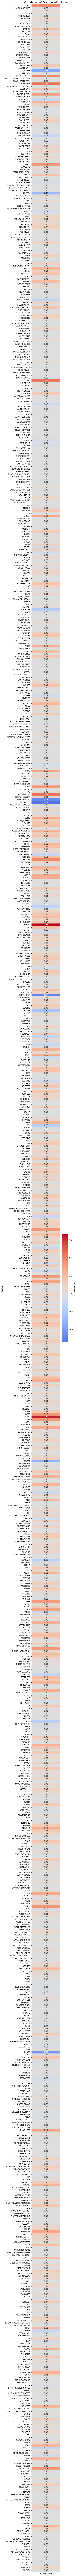

In [135]:
# --- if you just ran the previous correlation code, corr_series already exists ---
plt.figure(figsize=(6, max(6, len(corr_series)/5)))  # auto height for many features
sns.heatmap(
    corr_series.to_frame(),      # convert to DataFrame for sns.heatmap
    annot=True, fmt=".2f",
    cmap="coolwarm", center=0,
    cbar_kws={'label': 'Correlation'},
)
plt.title(f"Correlation of Features with {score_col}", fontsize=14)
plt.xlabel("")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

As shown by the heatmap the 30 best features were the ones shown before in orangey/red.


In [136]:
#defining features and target
feature_list = top_features.index.tolist()

score_col = "total_score"
if "Score" in df.columns: score_col = "Score"
elif "score" in df.columns: score_col = "score"
else: df[score_col] = df[feature_list].sum(axis=1) 
df_filtered = df[feature_list + [score_col]] 
df_filtered.to_csv("BordeauxWines_top30.csv",index=False)

X = df_filtered[feature_list].to_numpy(dtype=np.float64) 
y = df_filtered[score_col].to_numpy(dtype=np.float64)

#train and testing
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)


In [137]:
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In [138]:
# Number of clusters 
n_clusters = 3
m = 1.5

Xexp = np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

centers.shape


(3, 31)

In [139]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.4673019622367526


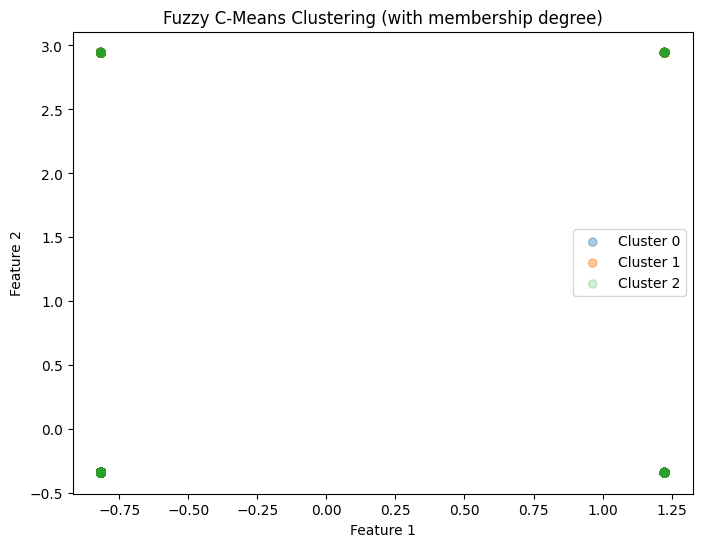

In [140]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

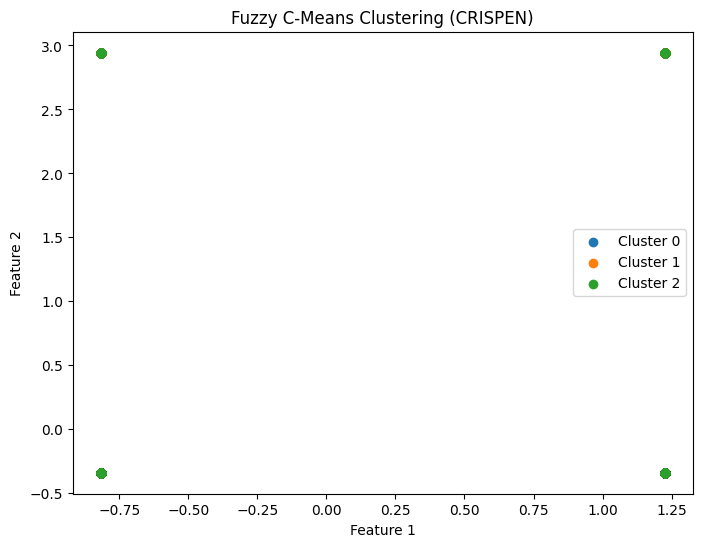

In [141]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

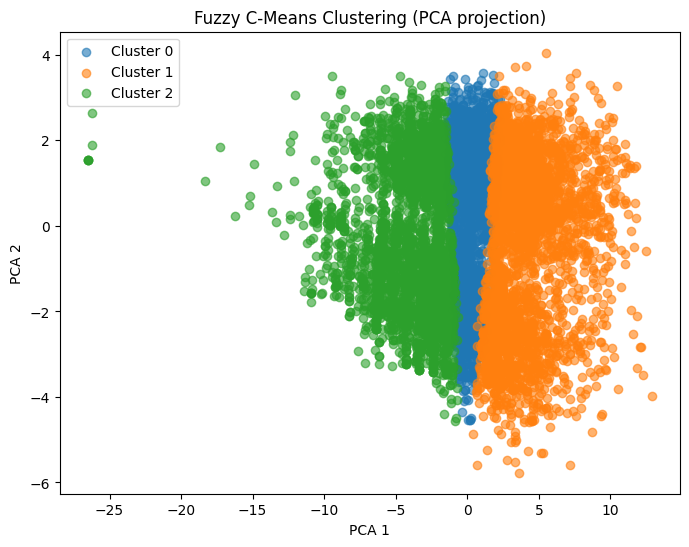

In [142]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Project Xexp (samples x features) into 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xexp)

# get crisp cluster labels from membership
cluster_labels = u.argmax(axis=0)

plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        X_pca[cluster_labels == j, 0],
        X_pca[cluster_labels == j, 1],
        label=f"Cluster {j}",
        alpha=0.6
    )
plt.title("Fuzzy C-Means Clustering (PCA projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


In [143]:
cluster_labels = u.argmax(axis=0)  # crisp label from fuzzy membership

# make sure ytr is a NumPy array
import numpy as np
import torch

if isinstance(ytr, np.ndarray):
    ytr_array = ytr.reshape(-1)
elif torch.is_tensor(ytr):
    ytr_array = ytr.cpu().numpy().reshape(-1)
else:  # likely a pandas Series or list
    ytr_array = np.array(ytr).reshape(-1)

df_clusters = pd.DataFrame({
    "Cluster": cluster_labels,
    "Score": ytr_array
})

# Average score by cluster
cluster_summary = df_clusters.groupby("Cluster")["Score"].agg(["mean", "count"]).sort_values("mean", ascending=False)
print(cluster_summary)

              mean  count
Cluster                  
1        91.468055   3553
0        87.981193   4041
2        84.280309   3885


In [144]:
#Remembeber to try diferent clusters and add it to the report

# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        #diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)
        diff = (x.unsqueeze(1) - self.centers.unsqueeze(0)) / (self.sigmas.unsqueeze(0) + eps)
        diff = torch.abs(diff)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)

# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1,n_rules))

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs




In [145]:
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

def ensure_float_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    elif hasattr(x, "values"):  # pandas DataFrame or Series
        return torch.tensor(x.values, dtype=torch.float32)
    else:  # numpy or list
        return torch.tensor(x, dtype=torch.float32)

Xtr = ensure_float_tensor(Xtr)
ytr = ensure_float_tensor(ytr)
Xte = ensure_float_tensor(Xte)
yte = ensure_float_tensor(yte)



In [146]:
# Least Squares Solver for Consequents (TSK)
#to get the optimal a and b already optimal
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

In [147]:
train_ls(model, Xtr, ytr.reshape(-1,1))



In [148]:
y_pred, _, _=model(Xte)

#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:749.5593872070312
VAF = -5995.62%


ANFIS

In [149]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

In [150]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=5, gd_epochs=10, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [151]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

C:\Users\kaliv\AppData\Local\Temp\ipykernel_8476\3955827078.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_8476\3955827078.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_8476\3955827078.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xte = torch.tensor(Xte, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_8476\3955827078.py:7: UserWar

In [152]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

tensor(771.3921, grad_fn=<MseLossBackward0>)
tensor(769.5107, grad_fn=<MseLossBackward0>)
tensor(767.6291, grad_fn=<MseLossBackward0>)
tensor(765.7462, grad_fn=<MseLossBackward0>)
tensor(763.8607, grad_fn=<MseLossBackward0>)
tensor(761.9749, grad_fn=<MseLossBackward0>)
tensor(760.0886, grad_fn=<MseLossBackward0>)
tensor(758.2024, grad_fn=<MseLossBackward0>)
tensor(756.3162, grad_fn=<MseLossBackward0>)
tensor(754.4299, grad_fn=<MseLossBackward0>)
tensor(744.2748, grad_fn=<MseLossBackward0>)
tensor(742.2570, grad_fn=<MseLossBackward0>)
tensor(740.2471, grad_fn=<MseLossBackward0>)
tensor(738.2444, grad_fn=<MseLossBackward0>)
tensor(736.2495, grad_fn=<MseLossBackward0>)
tensor(734.2638, grad_fn=<MseLossBackward0>)
tensor(732.2919, grad_fn=<MseLossBackward0>)
tensor(730.3264, grad_fn=<MseLossBackward0>)
tensor(728.3660, grad_fn=<MseLossBackward0>)
tensor(726.4100, grad_fn=<MseLossBackward0>)
tensor(722.0260, grad_fn=<MseLossBackward0>)
tensor(719.8754, grad_fn=<MseLossBackward0>)
tensor(717

In [153]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:575.8641357421875
VAF = -4764.83%


Plot by score


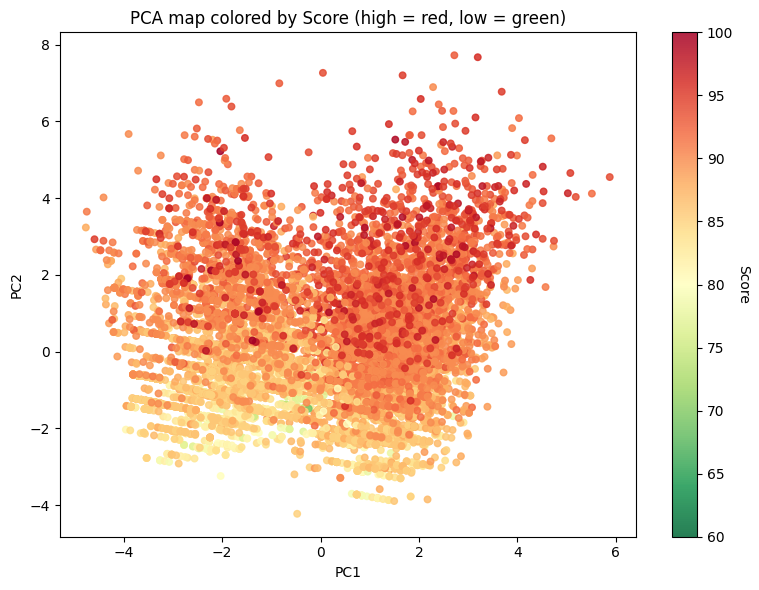

In [154]:
# PCA scatter colored by Score (high=red, low=green)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA

# --- 1) Load data ---
csv_path = "BordeauxWines_top30.csv"   # <- change path if needed
df = pd.read_csv(csv_path)

# --- 2) Pick numeric features and the Score column ---
score_col = [c for c in df.columns if c.lower() == "score"][0]  # finds 'Score' case-insensitively
num_cols  = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in num_cols if c != score_col]
assert len(feature_cols) >= 2, "Need at least 2 numeric feature columns besides Score."

# Keep only complete rows
mask = df[feature_cols + [score_col]].notnull().all(axis=1)
X = df.loc[mask, feature_cols].values
y = pd.to_numeric(df.loc[mask, score_col], errors="coerce").values

# --- 3) Preprocess then PCA to 2D ---
X = StandardScaler().fit_transform(X)
X = PowerTransformer(method="yeo-johnson").fit_transform(X)
X_2d = PCA(n_components=2, random_state=42).fit_transform(X)

# --- 4) Plot ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="RdYlGn_r", s=22, alpha=0.85)
cb = plt.colorbar(sc)
cb.set_label("Score", rotation=270, labelpad=12)
plt.title("PCA map colored by Score (high = red, low = green)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

embedded

In [155]:
! pip install "scikit-learn>=1.6,<1.8"


In [156]:
import umap, sklearn
print("umap:", umap.__version__)
print("scikit-learn:", sklearn.__version__)


umap: 0.5.5
scikit-learn: 1.5.2


In [157]:
# Patch sklearn so calls with 'ensure_all_finite' get mapped to 'force_all_finite'
import inspect
from sklearn.utils import validation as skval

if "ensure_all_finite" not in inspect.signature(skval.check_array).parameters:
    _orig_check_array = skval.check_array
    def _check_array_compat(*args, **kwargs):
        if "ensure_all_finite" in kwargs:
            kwargs["force_all_finite"] = kwargs.pop("ensure_all_finite")
        return _orig_check_array(*args, **kwargs)
    skval.check_array = _check_array_compat


In [158]:
# --- A2. Scale (UMAP likes standardized input) ---
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

# --- A3. Fit UMAP on train, transform both ---
umap_model = UMAP(
    n_components=2,     # change to 3 or more if you want
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)
Ztr = umap_model.fit_transform(Xtr_s)
Zte = umap_model.transform(Xte_s)

# Embedded features to use everywhere below
Xtr_emb, Xte_emb = Ztr, Zte

print("Z shapes:", Xtr_emb.shape, Xte_emb.shape)

c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\kaliv\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Z shapes: (11479, 2) (2870, 2)


In [159]:
# Number of clusters 
n_clusters = 3
m = 1.5

#Xexp = np.concatenate([Xtr_emb, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
#Xexp_T = Xexp.T 
Xexp_T = Xtr_emb.T

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

centers.shape


(3, 2)

In [160]:
sigmas = np.zeros((n_clusters, Xtr_emb.shape[1]))
for i in range(n_clusters):
    # Weighted covariance based on membership degrees
    weights = u[i, :]
    diff = Xtr_emb - centers[i, :]
    weighted_var = np.sum(weights[:, None] * diff**2, axis=0) / np.sum(weights)
    sigmas[i, :] = np.sqrt(weighted_var)


In [161]:
# Build model
model = TSK(n_inputs=Xtr_emb.shape[1], n_rules=n_clusters, centers=centers, sigmas=sigmas)

Xtr = torch.tensor(Xtr_emb, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte_emb, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

C:\Users\kaliv\AppData\Local\Temp\ipykernel_8476\3247704221.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\kaliv\AppData\Local\Temp\ipykernel_8476\3247704221.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yte = torch.tensor(yte, dtype=torch.float32)


In [162]:
train_ls(model, Xtr, ytr.reshape(-1,1))

In [163]:
y_pred, _, _=model(Xte)

#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

import numpy as np
import torch

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:10.929479598999023
VAF = -12.03%


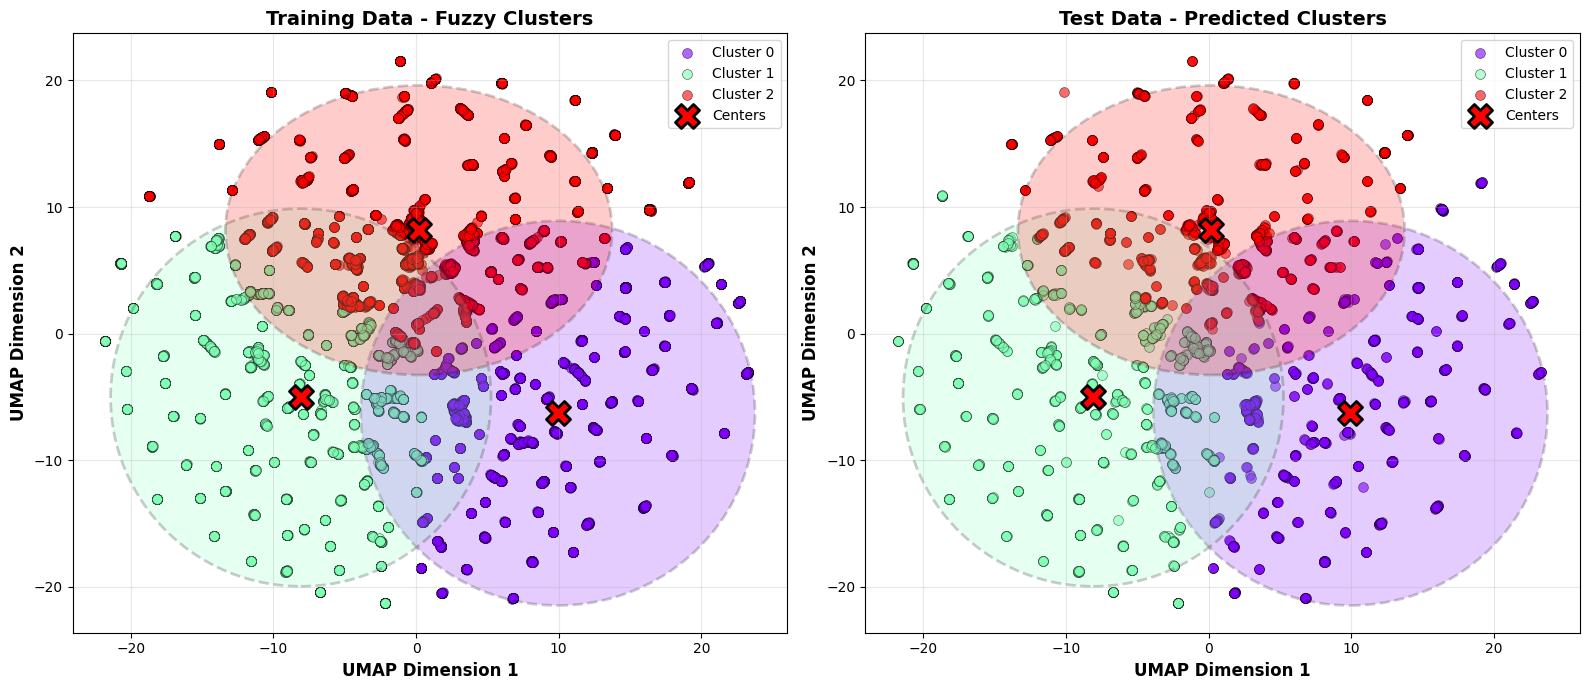

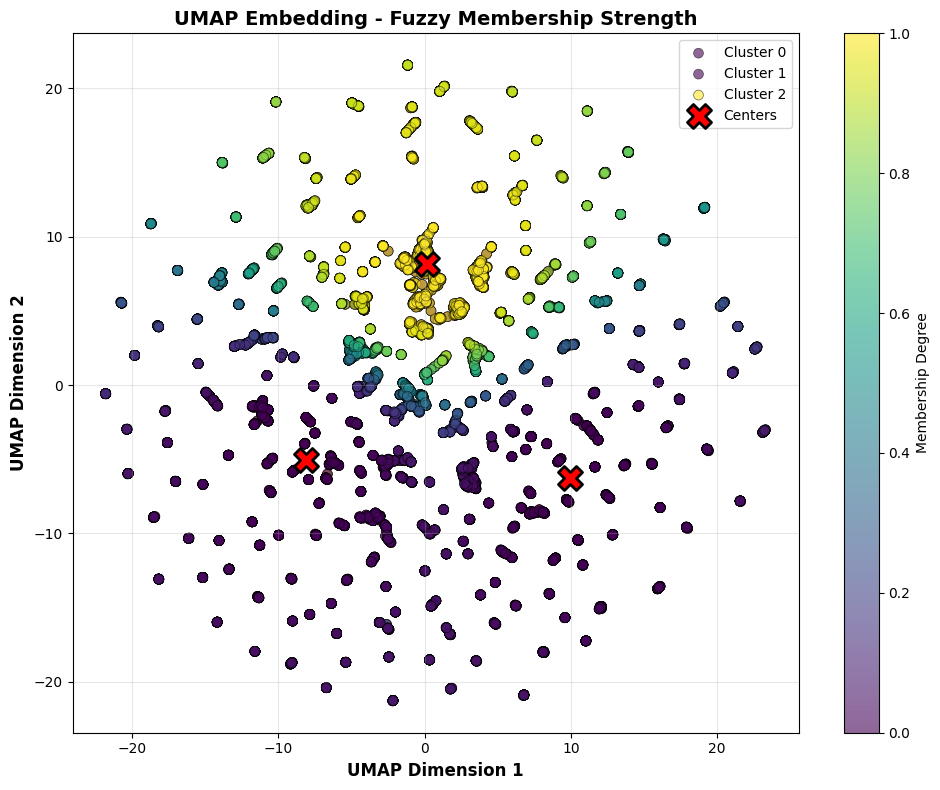


CLUSTER STATISTICS

Cluster 0:
  Training samples: 3160
  Test samples: 864
  Center: [9.939, -6.278]
  Sigma: [6.909, 7.593]

Cluster 1:
  Training samples: 3489
  Test samples: 1012
  Center: [-8.079, -5.039]
  Sigma: [6.666, 7.457]

Cluster 2:
  Training samples: 4830
  Test samples: 994
  Center: [0.191, 8.170]
  Sigma: [6.776, 5.717]


In [164]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

# Assuming you have:
# Xtr_emb, Xte_emb (UMAP embeddings)
# ytr, yte (labels)
# u (fuzzy membership matrix from cmeans)
# centers (cluster centers)
# sigmas (cluster spreads)

# --- 1. Plot Training Data with Fuzzy Membership ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Training data colored by fuzzy membership
ax1 = axes[0]

# Get hard cluster assignments (max membership)
cluster_labels = np.argmax(u, axis=0)

# Create colormap
colors = cm.rainbow(np.linspace(0, 1, n_clusters))

# Plot each point colored by its primary cluster
for i in range(n_clusters):
    mask = cluster_labels == i
    ax1.scatter(Xtr_emb[mask, 0], Xtr_emb[mask, 1], 
               c=[colors[i]], label=f'Cluster {i}',
               alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

# Plot cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], 
           c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2,
           label='Centers', zorder=5)

# Add ellipses to show cluster spread (2 sigma)
for i in range(n_clusters):
    ellipse = Ellipse(xy=(centers[i, 0], centers[i, 1]),
                     width=4*sigmas[i, 0], height=4*sigmas[i, 1],
                     alpha=0.2, facecolor=colors[i], edgecolor='black',
                     linewidth=2, linestyle='--')
    ax1.add_patch(ellipse)

ax1.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax1.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax1.set_title('Training Data - Fuzzy Clusters', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# --- 2. Plot Test Data with Predicted Clusters ---
ax2 = axes[1]

# You need to compute membership for test data
# Transform test data through the fuzzy model
Xte_T = Xte_emb.T
u_test = np.zeros((n_clusters, Xte_emb.shape[0]))

for i in range(n_clusters):
    diff = Xte_emb - centers[i, :]
    dist = np.sqrt(np.sum((diff / sigmas[i, :])**2, axis=1))
    u_test[i, :] = 1.0 / (dist**(2/(m-1)) + 1e-10)

# Normalize memberships
u_test = u_test / (np.sum(u_test, axis=0, keepdims=True) + 1e-10)

# Get hard cluster assignments for test data
cluster_labels_test = np.argmax(u_test, axis=0)

# Plot each point colored by its primary cluster
for i in range(n_clusters):
    mask = cluster_labels_test == i
    ax2.scatter(Xte_emb[mask, 0], Xte_emb[mask, 1], 
               c=[colors[i]], label=f'Cluster {i}',
               alpha=0.6, s=50, edgecolors='k', linewidth=0.5)

# Plot cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], 
           c='red', marker='X', s=300, 
           edgecolors='black', linewidth=2,
           label='Centers', zorder=5)

# Add ellipses
for i in range(n_clusters):
    ellipse = Ellipse(xy=(centers[i, 0], centers[i, 1]),
                     width=4*sigmas[i, 0], height=4*sigmas[i, 1],
                     alpha=0.2, facecolor=colors[i], edgecolor='black',
                     linewidth=2, linestyle='--')
    ax2.add_patch(ellipse)

ax2.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax2.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax2.set_title('Test Data - Predicted Clusters', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 3. Optional: Plot with membership strength ---
fig, ax = plt.subplots(figsize=(10, 8))

# Use membership strength as alpha (transparency)
for i in range(n_clusters):
    membership_strength = u[i, :]
    scatter = ax.scatter(Xtr_emb[:, 0], Xtr_emb[:, 1],
                        c=membership_strength, cmap='viridis',
                        alpha=0.6, s=50, edgecolors='k', linewidth=0.5,
                        vmin=0, vmax=1, label=f'Cluster {i}')
    
plt.colorbar(scatter, ax=ax, label='Membership Degree')

# Plot cluster centers
ax.scatter(centers[:, 0], centers[:, 1], 
          c='red', marker='X', s=300, 
          edgecolors='black', linewidth=2,
          label='Centers', zorder=5)

ax.set_xlabel('UMAP Dimension 1', fontsize=12, fontweight='bold')
ax.set_ylabel('UMAP Dimension 2', fontsize=12, fontweight='bold')
ax.set_title('UMAP Embedding - Fuzzy Membership Strength', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.show()

# --- 4. Print cluster statistics ---
print("\n" + "="*50)
print("CLUSTER STATISTICS")
print("="*50)
for i in range(n_clusters):
    train_count = np.sum(cluster_labels == i)
    test_count = np.sum(cluster_labels_test == i)
    print(f"\nCluster {i}:")
    print(f"  Training samples: {train_count}")
    print(f"  Test samples: {test_count}")
    print(f"  Center: [{centers[i, 0]:.3f}, {centers[i, 1]:.3f}]")
    print(f"  Sigma: [{sigmas[i, 0]:.3f}, {sigmas[i, 1]:.3f}]")

ANFIS- training with the embedded clusters


In [165]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

tensor(10.5452, grad_fn=<MseLossBackward0>)
tensor(10.5448, grad_fn=<MseLossBackward0>)
tensor(10.5443, grad_fn=<MseLossBackward0>)
tensor(10.5439, grad_fn=<MseLossBackward0>)
tensor(10.5434, grad_fn=<MseLossBackward0>)
tensor(10.5430, grad_fn=<MseLossBackward0>)
tensor(10.5425, grad_fn=<MseLossBackward0>)
tensor(10.5421, grad_fn=<MseLossBackward0>)
tensor(10.5417, grad_fn=<MseLossBackward0>)
tensor(10.5412, grad_fn=<MseLossBackward0>)
tensor(10.5408, grad_fn=<MseLossBackward0>)
tensor(10.5403, grad_fn=<MseLossBackward0>)
tensor(10.5399, grad_fn=<MseLossBackward0>)
tensor(10.5394, grad_fn=<MseLossBackward0>)
tensor(10.5390, grad_fn=<MseLossBackward0>)
tensor(10.5386, grad_fn=<MseLossBackward0>)
tensor(10.5381, grad_fn=<MseLossBackward0>)
tensor(10.5377, grad_fn=<MseLossBackward0>)
tensor(10.5372, grad_fn=<MseLossBackward0>)
tensor(10.5368, grad_fn=<MseLossBackward0>)
tensor(10.5363, grad_fn=<MseLossBackward0>)
tensor(10.5359, grad_fn=<MseLossBackward0>)
tensor(10.5354, grad_fn=<MseLoss

In [166]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)    
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:10.91001033782959
VAF = -12.21%


MSE: 10.91001033782959
R² Score: 0.10029923915863037


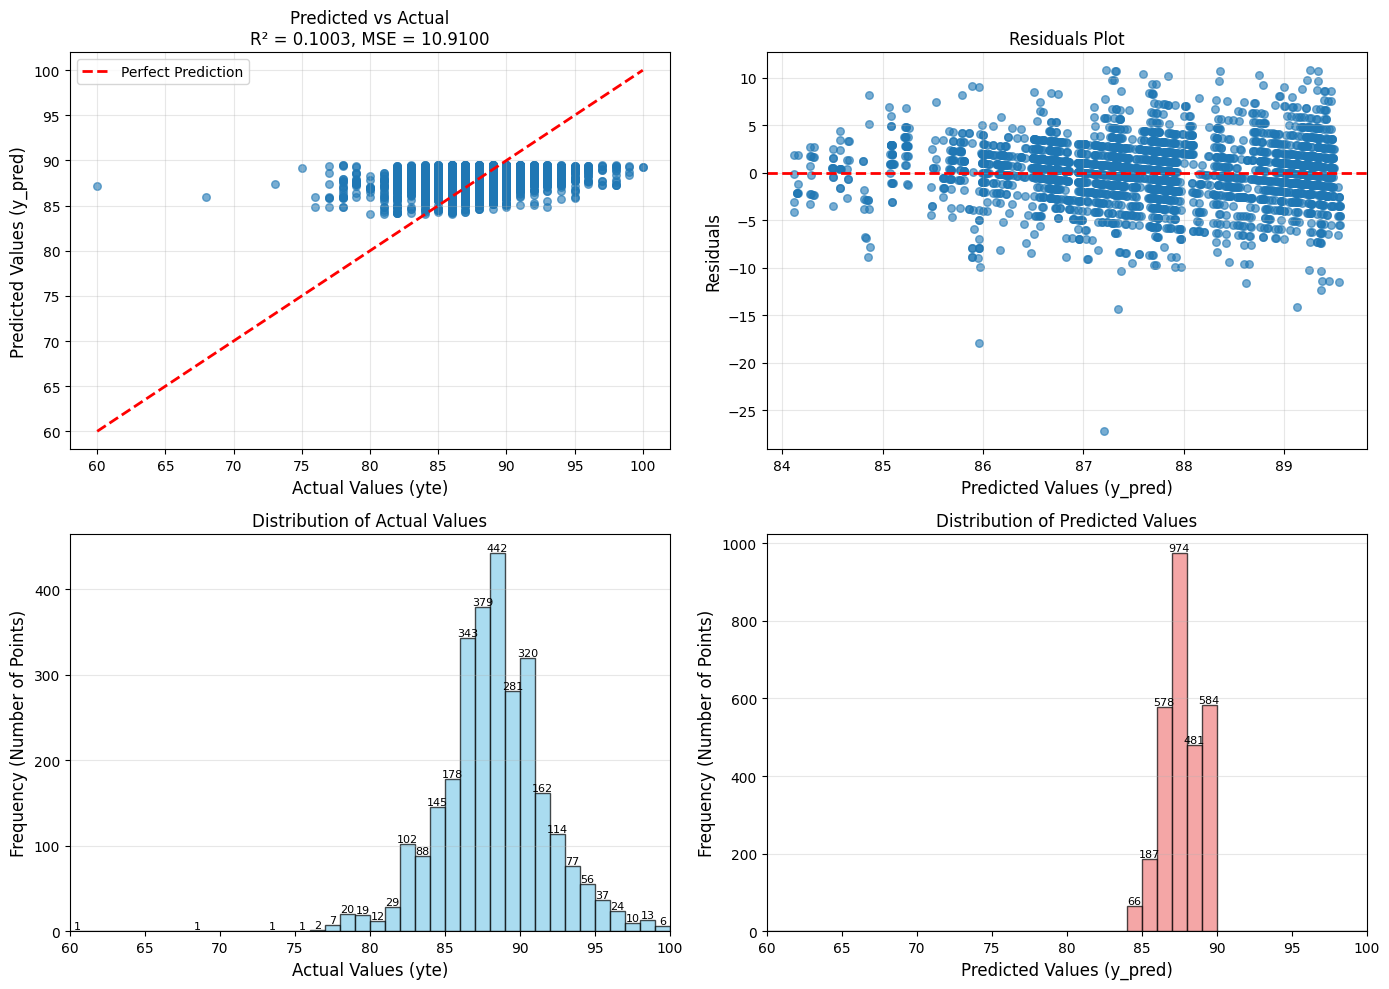

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Your existing code
train_ls(model, Xtr, ytr.reshape(-1,1))
y_pred, _, _ = model(Xte)

# Convert to numpy and flatten
y_actual = yte.detach().numpy().flatten()
y_predicted = y_pred.detach().numpy().flatten()

# Calculate metrics
mse = mean_squared_error(y_actual, y_predicted)
r2 = r2_score(y_actual, y_predicted)

print(f'MSE: {mse}')
print(f'R² Score: {r2}')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Scatter plot of Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(y_actual, y_predicted, alpha=0.6, s=30)
# Add perfect prediction line
min_val = min(y_actual.min(), y_predicted.min())
max_val = max(y_actual.max(), y_predicted.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values (yte)', fontsize=12)
ax1.set_ylabel('Predicted Values (y_pred)', fontsize=12)
ax1.set_title(f'Predicted vs Actual\nR² = {r2:.4f}, MSE = {mse:.4f}', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals plot
ax2 = axes[0, 1]
residuals = y_actual - y_predicted
ax2.scatter(y_predicted, residuals, alpha=0.6, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Values (y_pred)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.set_title('Residuals Plot', fontsize=12)
ax2.grid(True, alpha=0.3)

# Plot 3: Histogram of actual values with counts on bars
ax3 = axes[1, 0]
# Create bins for each integer value
min_val = min(y_actual.min(), y_predicted.min())
max_val = max(y_actual.max(), y_predicted.max())
bins = np.arange(np.floor(min_val), np.ceil(max_val) + 1, 1)  # Bins of size 1 (each integer)
counts, bin_edges, patches = ax3.hist(y_actual.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
# Add count labels on top of each bar
for count, patch in zip(counts, patches):
    if count > 0:  # Only show label if there are points
        height = patch.get_height()
        ax3.text(patch.get_x() + patch.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=8)
ax3.set_xlabel('Actual Values (yte)', fontsize=12)
ax3.set_ylabel('Frequency (Number of Points)', fontsize=12)
ax3.set_title('Distribution of Actual Values', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Histogram of predicted values with counts on bars
ax4 = axes[1, 1]
counts, bin_edges, patches = ax4.hist(y_predicted.flatten(), bins=bins, edgecolor='black', alpha=0.7, color='lightcoral')
# Add count labels on top of each bar
for count, patch in zip(counts, patches):
    if count > 0:  # Only show label if there are points
        height = patch.get_height()
        ax4.text(patch.get_x() + patch.get_width()/2., height,
                f'{int(count)}', ha='center', va='bottom', fontsize=8)
ax4.set_xlabel('Predicted Values (y_pred)', fontsize=12)
ax4.set_ylabel('Frequency (Number of Points)', fontsize=12)
ax4.set_title('Distribution of Predicted Values', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Set the same x-axis limits for both histograms
ax3.set_xlim(np.floor(min_val), np.ceil(max_val))
ax4.set_xlim(np.floor(min_val), np.ceil(max_val))

plt.tight_layout()
plt.show()